In [12]:
library(dplyr)
library(tidyr)
library(ggsci)
library(lfe)
library(stringr)
library(doMC)
library(fixest)
library(ggplot2)

In [13]:
df <- data.table::fread('/pool001/mfzhao/PROCESSED_DATA/dyadic_mvmt_2020.csv')

In [14]:
df %>% 
    filter(origin_cluster != destination_cluster) %>%
    mutate(oRain  = as.numeric(oPRCP > 0),
           dRain  = as.numeric(dPRCP > 0),
           nearby = as.numeric(dist < 100)) -> df

In [15]:
df %>%
    group_by(dyad) %>%
    mutate_at(vars(op1, op2, op3, dp1, dp2, dp3),
              .funs = list(l01 = function(x) lag(x) - lag(x, 2),
                           l02 = function(x) lag(x, 2) - lag(x, 3),
                           l03 = function(x) lag(x, 3) - lag(x, 4),
                           l04 = function(x) lag(x, 4) - lag(x, 5),
                           l05 = function(x) lag(x, 5) - lag(x, 6),
                           l06 = function(x) lag(x, 6) - lag(x, 7),
                           l07 = function(x) lag(x, 7) - lag(x, 8),
                           l08 = function(x) lag(x, 8) - lag(x, 9),
                           l09 = function(x) lag(x, 9) - lag(x, 10),
                           l10 = function(x) lag(x, 10) - lag(x, 11),
                           l11 = function(x) lag(x, 11) - lag(x, 12),
                           l12 = function(x) lag(x, 12) - lag(x, 13),
                           l13 = function(x) lag(x, 13) - lag(x, 14),
                           l14 = function(x) lag(x, 14),
                           m01 = function(x) lead(x) - x,
                           m02 = function(x) lead(x, 2) - lead(x, 1),
                           m03 = function(x) lead(x, 3) - lead(x, 2),
                           m04 = function(x) lead(x, 4) - lead(x, 3),
                           m05 = function(x) lead(x, 5) - lead(x, 4),
                           m06 = function(x) lead(x, 6) - lead(x, 5),
                           m07 = function(x) lead(x, 7) - lead(x, 6),
                           m08 = function(x) lead(x, 8) - lead(x, 7),
                           m09 = function(x) lead(x, 9) - lead(x, 8),
                           m10 = function(x) lead(x, 10) - lead(x, 9),
                           m11 = function(x) lead(x, 11) - lead(x, 10),
                           m12 = function(x) lead(x, 12) - lead(x, 11),
                           m13 = function(x) lead(x, 13) - lead(x, 12),
                           m14 = function(x) lead(x, 14) - lead(x, 13))) %>%
    mutate_at(vars(op1, op2, op3, dp1, dp2, dp3), ~(. - lag(.))) -> df
                           
df %>%
    fill(matches('[od]p[123]'), .direction = 'up') %>%
    fill(matches("m[01][0-9]"), .direction = 'down') %>%
    fill(matches("l[01][0-9]"), .direction = 'up') -> df

In [16]:
cns <- colnames(df)
lnl <- str_c(cns[str_detect(cns, '[od]p[123]_[ml][012][0-9]')], collapse = ' + ')

In [17]:
wctrls  <- str_c(cns[str_detect(cns, '[od][pt][rm][ca][px]..')], collapse = ' + ')
cdctrls <- str_c(cns[str_detect(cns, '[od][acs][st]_')], collapse = ' + ')
ctrls   <- str_c(wctrls, ' + ', cdctrls)

In [18]:
get_coefs <- function(dv, type) {
    if(type == 'all') {
        temp <- df
    } else {
        temp <- df %>%
            filter(nearby == ifelse(type == 'nearby', 1, 0))
    }
    
    if(dv == 'ndotd') {
        form <- str_c('log(ndotd) ~ op1 + op2 + op3 + dp1 + dp2 + dp3 + ', lnl, ' + ', ctrls, ' | dyad + date')
        fit  <- feols(as.formula(form), temp, nthread = 20)
    } else {
        form <- str_c('log(pdotd) ~ op1 + op2 + op3 + dp1 + dp2 + dp3 + ', lnl, ' + ', ctrls, ' | dyad + date')
        fit  <- feols(as.formula(form), temp, weights = temp$n, nthread = 20)
    }

    out <- summary(fit)$coeftable %>%
        mutate(var  = rownames(.),
               dv   = dv, 
               type = type) %>%
        filter(str_detect(var, '[od]p[123]')) %>%
        rename(estimate = Estimate, se = `Std. Error`)
    
    return(out)
}

In [19]:
foreach(dv = c('ndotd', 'pdotd'), .combine = rbind) %:%
    foreach(type = c('all', 'nearby', 'distant'), .combine = rbind) %do%
    get_coefs(dv, type) -> dyad_coefs

NOTE: 24,388 observations removed because of NA values (RHS: 24,388).

NOTE: 9,464 observations removed because of NA values (RHS: 9,464).

NOTE: 14,924 observations removed because of NA values (RHS: 14,924).

NOTE: 24,388 observations removed because of NA values (RHS: 24,388).

NOTE: 9,464 observations removed because of NA values (RHS: 9,464).

NOTE: 14,924 observations removed because of NA values (RHS: 14,924).



Warning message:
“Expected 2 pieces. Missing pieces filled with `NA` in 36 rows [1, 2, 3, 4, 5, 6, 175, 176, 177, 178, 179, 180, 349, 350, 351, 352, 353, 354, 523, 524, ...].”


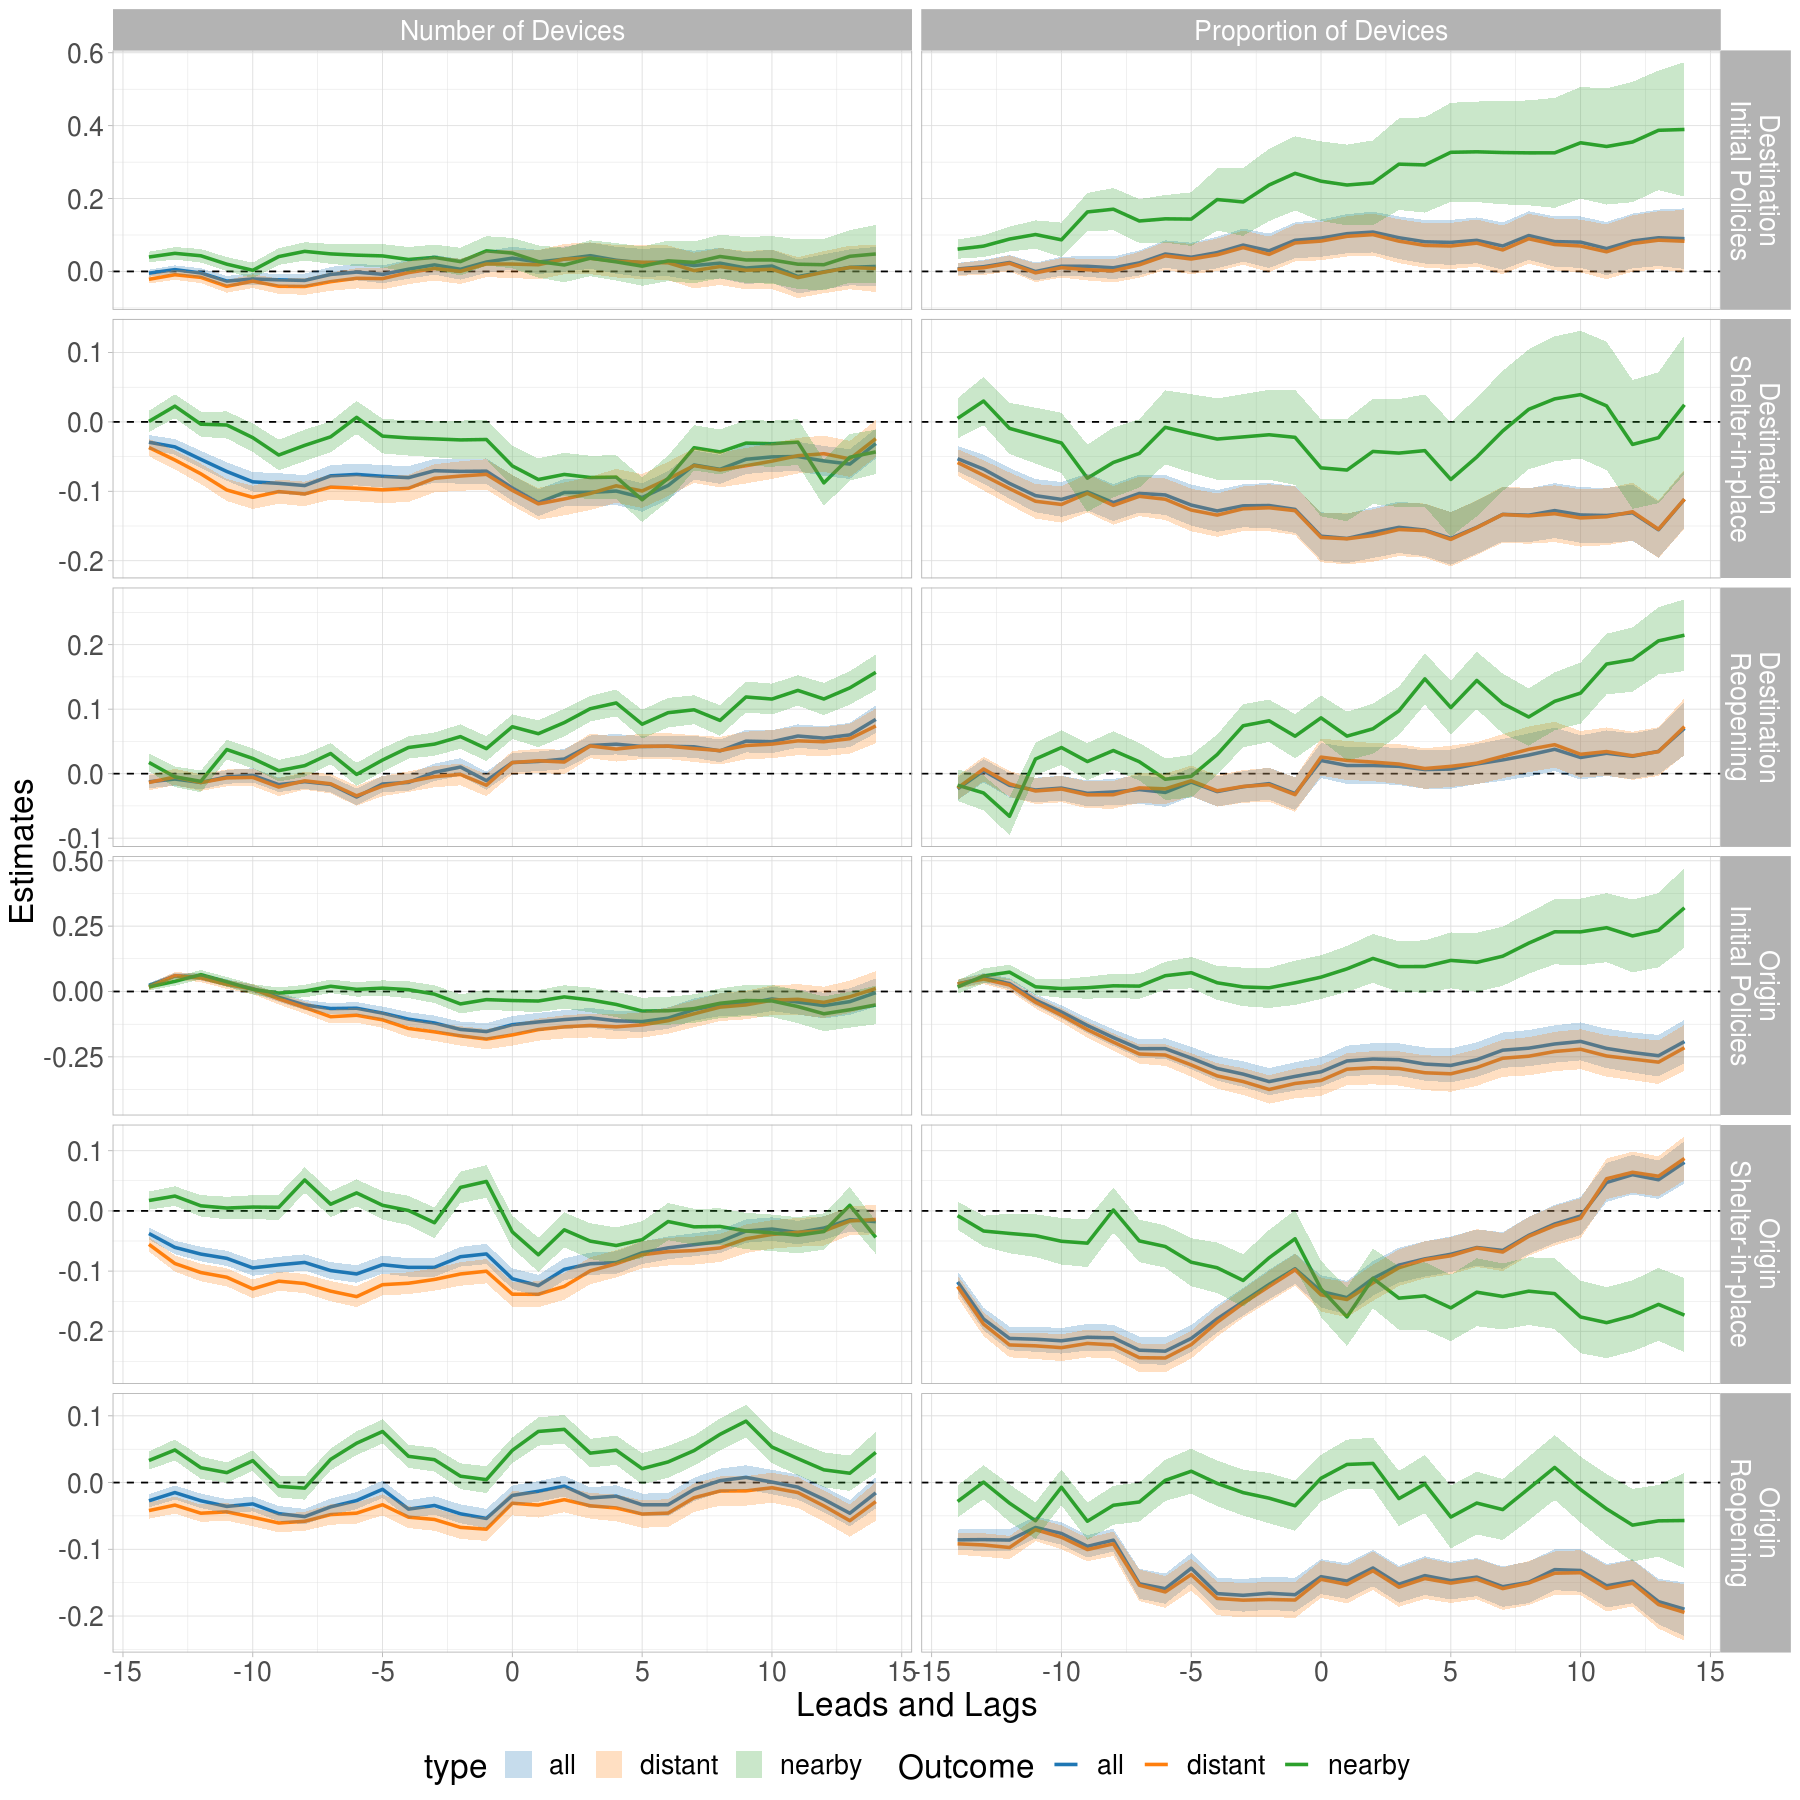

In [20]:
vns <- c('dp1'   = "Destination\nInitial Policies",
         'dp2'   = "Destination\nShelter-in-place",
         'dp3'   = "Destination\nReopening",
         'op1'   = 'Origin\nInitial Policies',
         'op2'   = 'Origin\nShelter-in-place',
         'op3'   = 'Origin\nReopening',
         'pdotd' = 'Proportion of Devices', 
         'ndotd' = 'Number of Devices')

options(repr.plot.width=15, repr.plot.height=15)

dyad_coefs %>%
    separate(var, into = c('var', 'll')) %>%
    mutate(ll = ifelse(is.na(ll), 0,
                      ifelse(str_detect(ll, 'l'), as.numeric(str_sub(ll, 2, 3)), -as.numeric(str_sub(ll, 2, 3))))) %>%
    ggplot(aes(x = ll, y = estimate, color = type, fill = type)) + 
    geom_hline(aes(yintercept = 0), linetype = 2) +
    geom_line(size = 1) + 
    geom_ribbon(aes(ymin = estimate - 1.98 * se, ymax = estimate + 1.98 * se), alpha = 0.25, color = NA) +
    facet_grid(var ~ dv, labeller = as_labeller(vns), scales = 'free') + 
    xlab('Leads and Lags') + 
    ylab('Estimates') +
    scale_color_d3() +
    scale_fill_d3() +
    labs(color = "Outcome") +
    theme_light() +
    theme(text = element_text(size=20),
          legend.position = 'bottom') -> p

p
ggsave('/home/mfzhao/SI_plots/rc2b_ll_dyad.pdf', p, device = 'pdf', width = 6.5, height = 6.5, scale = 2)